# Chapter 8

# Question 8

Predicting `Sales` using regression trees

In [1]:
import statsmodels.api as sm
import sklearn.model_selection
import sklearn.ensemble
import sklearn.tree
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np
from IPython.display import Image

In [2]:
carseat_sales = sm.datasets.get_rdataset("Carseats", "ISLR").data
carseat_sales.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No

In [3]:
X = carseat_sales.drop(columns="Sales")
# One-hot the categoricals
for col in ["ShelveLoc", "Urban", "US"]:

    X = pd.concat([X, pd.get_dummies(X[col], prefix=col, drop_first=True)],axis=1).drop(columns=col)

    
y = carseat_sales.Sales

### (a) Split the data into a training set and a test set

In [4]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [5]:
tree = sklearn.tree.DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [6]:
y_pred = tree.predict(X_test)
test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print(f"mean value of Sales: {y.mean():.2f}")
print(f"test MSE: {test_mse:.2f}")

mean value of Sales: 7.50
test MSE: 5.89


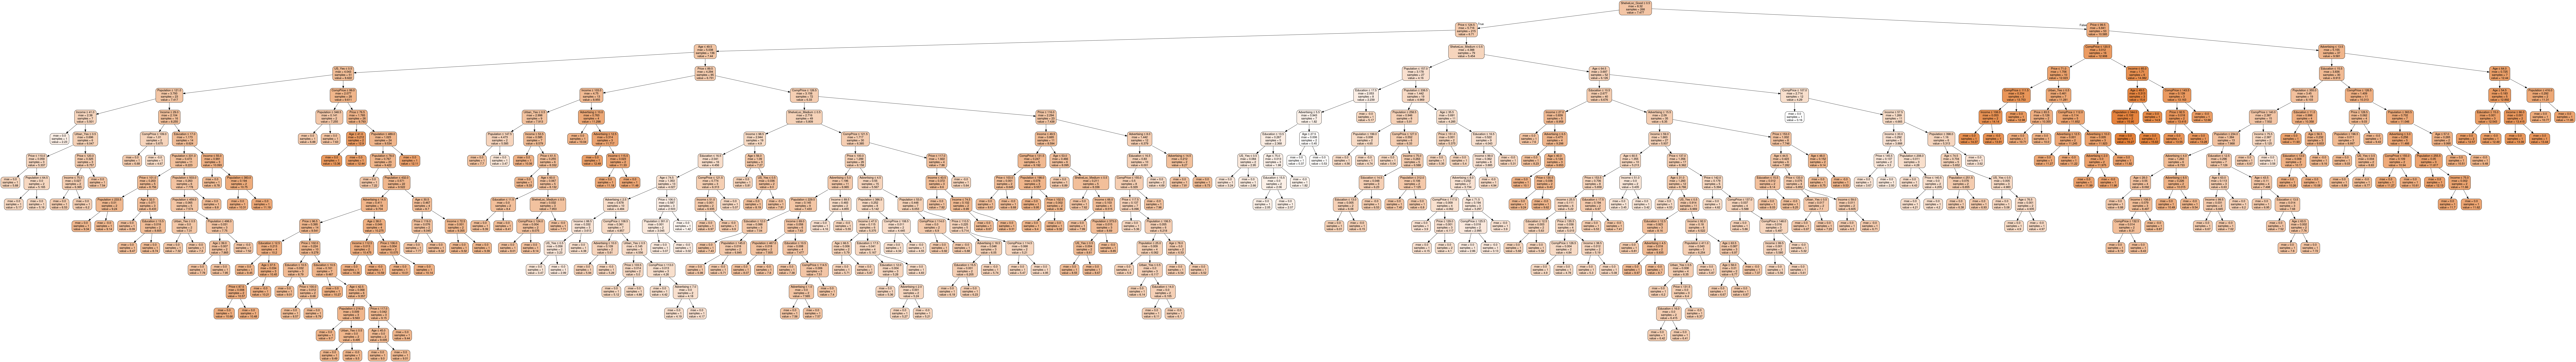

In [7]:
dot_data = sklearn.tree.export_graphviz(tree, out_file=None, 
                      feature_names=X.columns,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("tree", format="png")
Image("tree.png")

This tree is horrendously over-fit - each leaf has only one sample!

### (c) Use cross-validation to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [8]:
parameters = {'max_depth':range(3,20)}
clf = sklearn.model_selection.GridSearchCV(sklearn.tree.DecisionTreeRegressor(), parameters, n_jobs=4, cv=5)
clf.fit(X=X_train, y=y_train)
best_tree = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.32609197414590757 {'max_depth': 3}


/home/will/.local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [9]:
y_pred = best_tree.predict(X_test)
test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
# print(f"mean value of Sales: {y.mean():.2f}")
print(f"test MSE on pruned tree: {test_mse:.2f}")

test MSE on pruned tree: 5.06


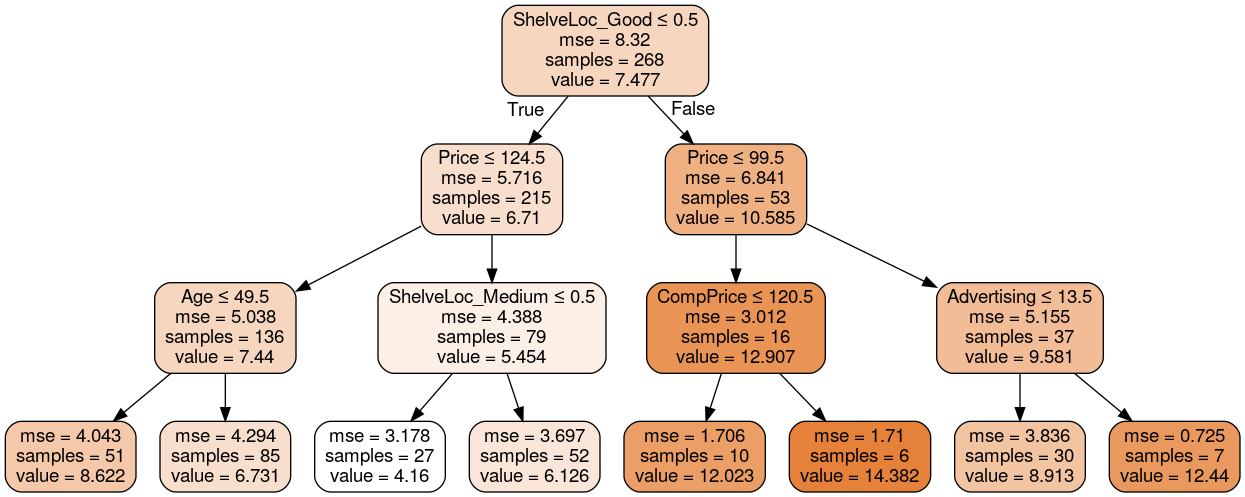

In [10]:
dot_data = sklearn.tree.export_graphviz(best_tree, out_file=None, 
                      feature_names=X.columns,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("tree", format="png")
Image("tree.png")

It'd be nice to have better viz of the decision surface itself - e.g. a plot with paired features

### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Get the feature importance to determine which variables are most important.

In [11]:
# A random forest, when all predictors are consider, is equivalent to using bagging
random_forest = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_features=None)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
# print(f"mean value of Sales: {y.mean():.2f}")
print(f"test MSE on random forest: {test_mse:.2f}")

test MSE on random forest: 2.28


Feature ranking:
1. ShelveLoc_Good: 0.28
2. Price: 0.26
3. Age: 0.10
4. Advertising: 0.09
5. CompPrice: 0.08
6. ShelveLoc_Medium: 0.06
7. Income: 0.06
8. Population: 0.04
9. Education: 0.03
10. US_Yes: 0.01
11. Urban_Yes: 0.01


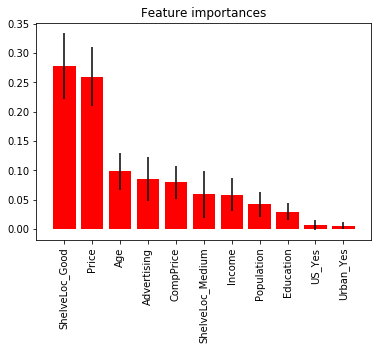

In [12]:
def getFeatureImportance(random_forest, X):
    """Given a trained classifier, plot the feature importance"""
    importances = random_forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    text_indices = [X.columns[i] for i in indices]
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print(f"{f+1}. {text_indices[f]}: {importances[indices[f]] :.2f}")

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), text_indices, rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

getFeatureImportance(random_forest, X)

### (e) Use random forests to analyse the data. What test MSE do you obtain? Get the feature importance. Describe the effect of `m`, the number of variables considered at each split, on the error rate

In [13]:
for m in range(1, len(X.columns)+1):
    # A random forest, when all predictors are consider, is equivalent to using bagging
    random_forest = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_features=m)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    # print(f"mean value of Sales: {y.mean():.2f}")
    print(f"test MSE on random forest with m={m}: {test_mse:.2f}")

test MSE on random forest with m=1: 3.77
test MSE on random forest with m=2: 3.13
test MSE on random forest with m=3: 2.77
test MSE on random forest with m=4: 2.65
test MSE on random forest with m=5: 2.39
test MSE on random forest with m=6: 2.43
test MSE on random forest with m=7: 2.39
test MSE on random forest with m=8: 2.42
test MSE on random forest with m=9: 2.34
test MSE on random forest with m=10: 2.37
test MSE on random forest with m=11: 2.35


It's a bit all over the place. Use the cross-val score instead:

CV MSE on random forest with m=1: 4.25
CV MSE on random forest with m=2: 3.41
CV MSE on random forest with m=3: 2.95
CV MSE on random forest with m=4: 2.81
CV MSE on random forest with m=5: 2.64
CV MSE on random forest with m=6: 2.55
CV MSE on random forest with m=7: 2.51
CV MSE on random forest with m=8: 2.52
CV MSE on random forest with m=9: 2.50
CV MSE on random forest with m=10: 2.50
CV MSE on random forest with m=11: 2.48


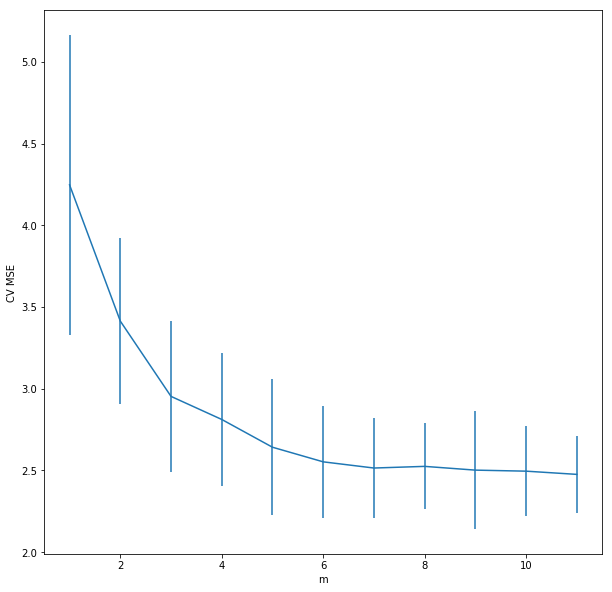

In [15]:
means = []
stds = []
for m in range(1, len(X.columns)+1):
    # A random forest, when all predictors are consider, is equivalent to using bagging
    random_forest = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_features=m)
    scores = sklearn.model_selection.cross_val_score(random_forest,X,y,cv=5,scoring="neg_mean_squared_error")
    score = -np.mean(scores)
    std = np.std(scores)
    means.append(score)
    stds.append(std)
#     random_forest.fit(X_train, y_train)
    
#     y_pred = random_forest.predict(X_test)
#     test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    # print(f"mean value of Sales: {y.mean():.2f}")
    print(f"CV MSE on random forest with m={m}: {score:.2f}")

fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(range(1, len(X.columns)+1), means, stds)

ax.set_xlabel("m")
ax.set_ylabel("CV MSE")
plt.show()